In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import bitfinex
from datetime import datetime
import time


from sklearn.model_selection import train_test_split

In [45]:
# api_v1 = bitfinex.bitfinex_v1.api_v1()
# pairs = api_v1.symbols()
# pairs

In [2]:
pair = 'btcusd'
interval = '1D'

t_start = datetime(2009, 1, 1, 0, 0)
t_start = time.mktime(t_start.timetuple()) * 1000

t_stop = datetime(2023, 1, 1, 0, 0)
t_stop = time.mktime(t_stop.timetuple()) * 1000

In [3]:
def fetch_data(start=1640991600000, stop=1651356000000, symbol='btcusd', interval='1D', step=31536000000):
    # Create api instance
    api_v2 = bitfinex.bitfinex_v2.api_v2()

    data = []
    names = ['time', 'open', 'close', 'high', 'low', 'volume']

    if stop > time.time() * 1000: # stop value can't be higher than datetime.now()
        stop = datetime.now()
        stop = time.mktime(stop.timetuple()) * 1000
    if stop - start > step: # if data requested > 365 days
        while start < stop:
            if start + step > stop: # if start + 365 days > stop => stop = now
                end = datetime.now()
                end = time.mktime(end.timetuple()) * 1000
            else:
                end = start + step
            print(datetime.fromtimestamp(start / 1000), datetime.fromtimestamp(end / 1000))
            res = api_v2.candles(symbol=symbol, interval=interval, start=start, end=end)
            data.extend(res)
            start += step
            time.sleep(1)
    else:
        res = api_v2.candles(symbol=symbol, interval=interval, start=start, end=stop)
        data.extend(res)
    #print(data)

    # Modify data to send back a clean DataFrame
    df = pd.DataFrame(data, columns=names)
    df['time'] = pd.to_datetime(df['time'], unit='ms')
    df = df.sort_values(by='time')
    df.reset_index(inplace=True)
    df.drop('index', axis=1, inplace=True)
    df.rename(columns={'time':'date'}, inplace=True)
    return df

In [4]:
df = fetch_data(start=t_start, stop=t_stop, symbol=pair)
df

No keys, only access to public API functions
2009-01-01 00:00:00 2010-01-01 00:00:00
2010-01-01 00:00:00 2011-01-01 00:00:00
2011-01-01 00:00:00 2012-01-01 00:00:00
2012-01-01 00:00:00 2012-12-31 00:00:00
2012-12-31 00:00:00 2013-12-31 00:00:00
2013-12-31 00:00:00 2014-12-31 00:00:00
2014-12-31 00:00:00 2015-12-31 00:00:00
2015-12-31 00:00:00 2016-12-30 00:00:00
2016-12-30 00:00:00 2017-12-30 00:00:00
2017-12-30 00:00:00 2018-12-30 00:00:00
2018-12-30 00:00:00 2019-12-30 00:00:00
2019-12-30 00:00:00 2020-12-29 00:00:00
2020-12-29 00:00:00 2021-12-29 00:00:00
2021-12-29 00:00:00 2022-05-11 15:05:39


,date,open,close,high,low,volume
0,2013-03-31,92.500000,93.033000,93.74999,91.00000,3083.079791
1,2013-04-01,93.250000,103.999000,105.90000,92.49999,5224.401313
2,2013-04-02,104.000000,118.229354,118.38670,99.00000,8376.527478
3,2013-04-03,117.958261,134.700000,146.88000,101.51088,12996.245072
4,2013-04-04,134.716560,132.899000,143.00000,119.00000,6981.668305
...,...,...,...,...,...,...
3317,2022-05-07,36041.000000,35506.000000,36170.00000,34854.00000,3781.181837
3318,2022-05-08,35506.000000,34064.000000,35541.00000,33761.00000,6577.706035
3319,2022-05-09,34075.000000,30140.000000,34277.00000,30100.00000,21250.245615
3320,2022-05-10,30136.000000,31072.000000,32687.00000,29833.00000,14172.682208


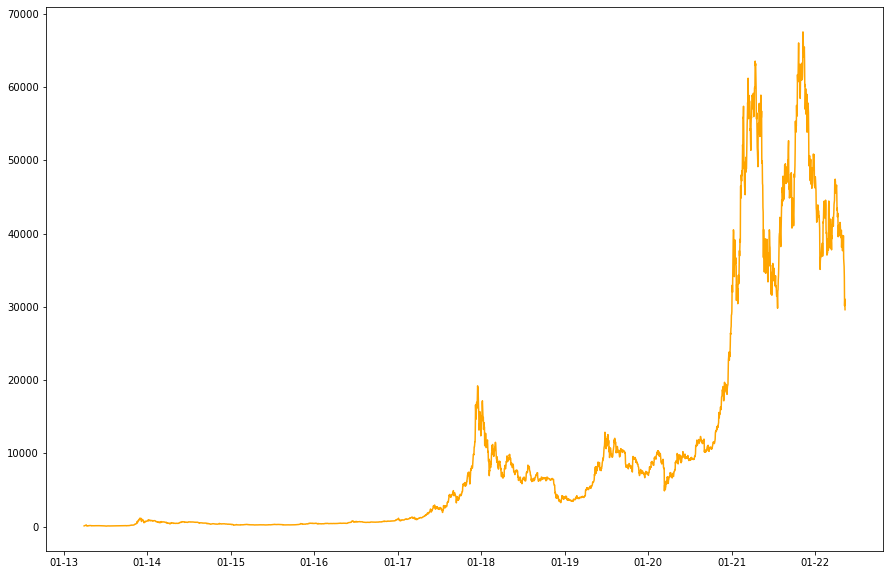

In [5]:
# ALL TIME PRICE
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot()
ax.plot(df['date'], df['close'], color="orange")
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%y'))

plt.show()

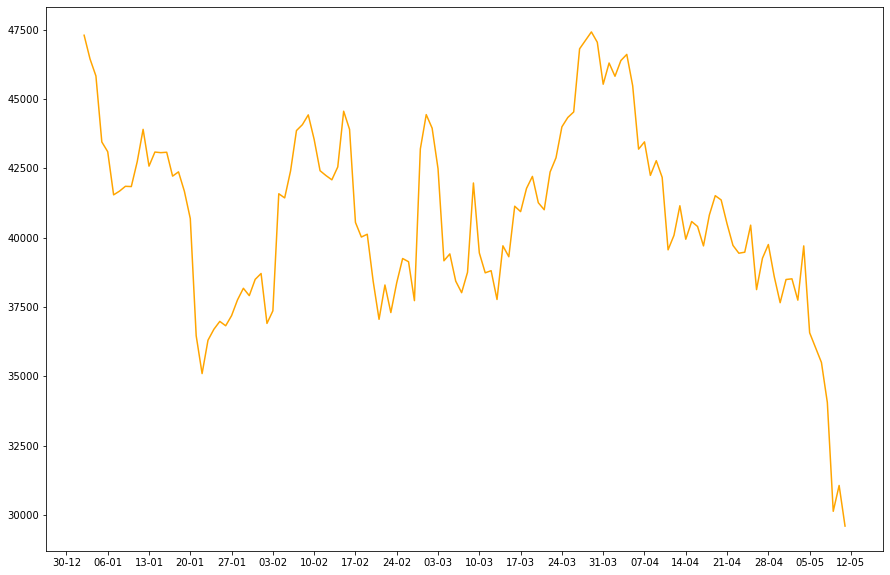

In [6]:
# 2022 WEEKLY PRICE 
current_year = df[df['date'] > '2022-01-01']

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot()
ax.plot(current_year['date'], current_year['close'], color="orange")
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))

plt.show()

# Define features

# LSTM Test

In [7]:
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score

In [8]:
np.random.seed(7)

In [9]:
data_without_time = df.drop('date', axis=1)
data_without_time

,open,close,high,low,volume
0,92.500000,93.033000,93.74999,91.00000,3083.079791
1,93.250000,103.999000,105.90000,92.49999,5224.401313
2,104.000000,118.229354,118.38670,99.00000,8376.527478
3,117.958261,134.700000,146.88000,101.51088,12996.245072
4,134.716560,132.899000,143.00000,119.00000,6981.668305
...,...,...,...,...,...
3317,36041.000000,35506.000000,36170.00000,34854.00000,3781.181837
3318,35506.000000,34064.000000,35541.00000,33761.00000,6577.706035
3319,34075.000000,30140.000000,34277.00000,30100.00000,21250.245615
3320,30136.000000,31072.000000,32687.00000,29833.00000,14172.682208


In [10]:
X = data_without_time.drop('close', axis=1).values
y = data_without_time['close'].values

In [11]:
X_scaler = MinMaxScaler(feature_range=(0,1))
y_scaler = MinMaxScaler(feature_range=(0,1))

X = X_scaler.fit_transform(np.array(X))
y = y_scaler.fit_transform(np.array(y).reshape(-1,1))

In [12]:
test_size = round(len(df)*0.2)
train_size = round(len(df) - test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1, shuffle=False)

In [14]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2658, 4, 1), (664, 4, 1), (2658, 1), (664, 1))

In [15]:
regressor = Sequential()
regressor.add(LSTM(4, input_shape=(X_train.shape[1], 1)))
regressor.add(Dense(1))
regressor.add(Dropout(0.2))
regressor.compile(loss='mean_squared_error', optimizer='adam')
regressor.fit(X_train, y_train, epochs=200, batch_size=5)

Epoch 1/200
532/532 [==============================] - 10s 7ms/step - loss: 0.0023
Epoch 2/200
532/532 [==============================] - 3s 6ms/step - loss: 0.0012
Epoch 3/200
532/532 [==============================] - 3s 6ms/step - loss: 0.0010
Epoch 4/200
532/532 [==============================] - 3s 6ms/step - loss: 0.0012
Epoch 5/200
532/532 [==============================] - 3s 6ms/step - loss: 0.0010
Epoch 6/200
532/532 [==============================] - 3s 6ms/step - loss: 0.0011
Epoch 7/200
532/532 [==============================] - 3s 5ms/step - loss: 0.0011
Epoch 8/200
532/532 [==============================] - 3s 5ms/step - loss: 0.0013
Epoch 9/200
532/532 [==============================] - 4s 7ms/step - loss: 0.0013
Epoch 10/200
532/532 [==============================] - 3s 6ms/step - loss: 0.0012
Epoch 11/200
532/532 [==============================] - 3s 6ms/step - loss: 0.0012
Epoch 12/200
532/532 [==============================] - 3s 6ms/step - loss: 0.0012
Epoch 13/200

In [16]:
# make predictions
trainPredict = regressor.predict(X_train)
testPredict = regressor.predict(X_test)

# invert predictions

# create empty table with 4 fields
trainPredict_dataset_like, testPredict_dataset_like = np.zeros(shape=(len(trainPredict), 4)), np.zeros(shape=(len(testPredict), 4))
# put the predicted values in the right field
trainPredict_dataset_like[:,0], testPredict_dataset_like[:,0] = trainPredict[:,0], testPredict[:,0]
# inverse transform and then select the right field
trainPredict = X_scaler.inverse_transform(trainPredict_dataset_like)[:,0]
testPredict = X_scaler.inverse_transform(testPredict_dataset_like)[:,0]
trainPredict = trainPredict.reshape(-1,1)
testPredict = testPredict.reshape(-1,1)

trainY = y_scaler.inverse_transform(y_train)
testY = y_scaler.inverse_transform(y_test)

In [61]:
testPredict.shape

(664, 1)

In [17]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(trainY,trainPredict)))
print("Train data MSE: ", mean_squared_error(trainY,trainPredict))
print("Test data MAE: ", mean_absolute_error(trainY,trainPredict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(testY,testPredict)))
print("Test data MSE: ", mean_squared_error(testY,testPredict))
print("Test data MAE: ", mean_absolute_error(testY,testPredict))

Train data RMSE:  965.650372792167
Train data MSE:  932480.642473651
Test data MAE:  611.0639088745767
-------------------------------------------------------------------------------------
Test data RMSE:  12004.775885191608
Test data MSE:  144114644.05367795
Test data MAE:  10501.558994622183


In [20]:
print("Train data explained variance regression score:", explained_variance_score(trainY, trainPredict))
print("Test data explained variance regression score:", explained_variance_score(testY, testPredict))

Train data explained variance regression score: 0.9621413512946144
Test data explained variance regression score: 0.8667318954869098


In [21]:
print("Train data R2 score:", r2_score(trainY, trainPredict))
print("Test data R2 score:", r2_score(testY, testPredict))

Train data R2 score: 0.9385390189168518
Test data R2 score: 0.43231435738635715


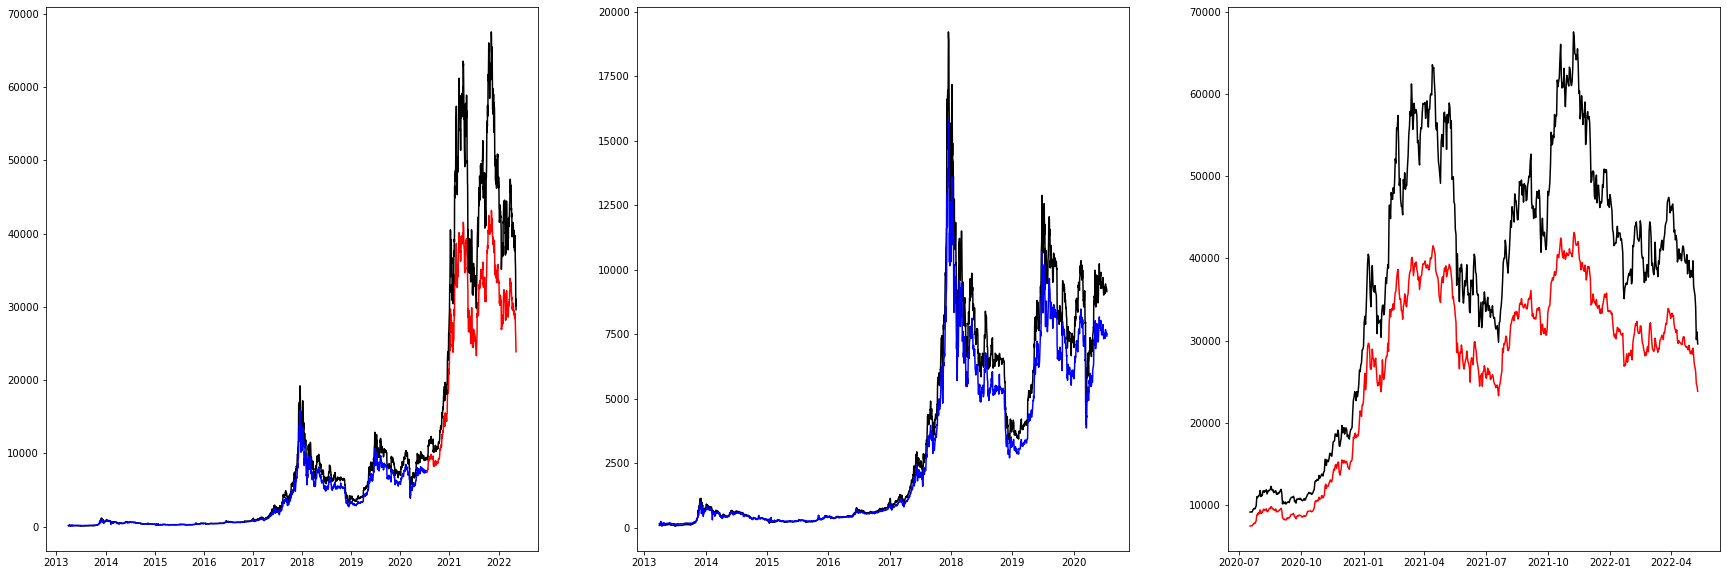

In [22]:
f,axs = plt.subplots(1,3,figsize=(30,10))

axs[0].plot(df['date'][:train_size], df['close'][:train_size], color='black')
axs[0].plot(df['date'][:train_size], trainPredict, color='blue')
axs[0].plot(df['date'][train_size:], testPredict, color='red')
axs[0].plot(df['date'][train_size:], df['close'][train_size:], color='black')
axs[1].plot(df['date'][:train_size], df['close'][:train_size], color='black')
axs[1].plot(df['date'][:train_size], trainPredict, color='blue')
axs[2].plot(df['date'][train_size:], testPredict, color='red')
axs[2].plot(df['date'][train_size:], df['close'][train_size:], color='black')

plt.show()

In [ ]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 10
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        
        yhat = my_model.predict(x_input)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[1:]
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        yhat = my_model.predict(x_input)
        
        temp_input.extend(yhat.tolist())
        lst_output.extend(yhat.tolist())
        
        i=i+1
        
print("Output of predicted next days: ", len(lst_output))

# Tuning


In [ ]:
def createLSTMModel(dropout_rate=0.1, loss='mae'):
    
    model = Sequential()
    model.add(LSTM(250, return_sequences=True, input_shape=(X_train.shape[1],1)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(170, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(25, return_sequences=True))
    model.add(Dropout(dropout_rate))
    #model.add(Flatten())
    model.add(Dense(1))
    model.compile(optimizer='Adam',loss=loss)
    return model

In [ ]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV


lstm_model = KerasRegressor(build_fn=createLSTMModel)

# parameters that we will try to tune

params_lstm = {
        'batch_size': [348,256,200,128],
        'epochs': [15,30],   
        'loss': ['logcosh', 'mae', 'mse', 'hinge','squared_hinge'],
        'dropout_rate':[0.1,0.2,0.4,0.6]  
        }

param_search = GridSearchCV(estimator=lstm_model,
                     param_grid=params_lstm,
                     scoring={'neg_mean_squared_error','r2','explained_variance','max_error','neg_mean_absolute_error','neg_median_absolute_error'},
                     refit='neg_median_absolute_error',
                     cv=2)
                
param_search.fit(X_train, y_train)

best_score = param_search.best_score_
best_params = param_search.best_params_

print(f'Best accuracy: {best_score} was obtained with parameters: {best_params}')


In [ ]:
final_model = Sequential()
final_model.add(LSTM(4, input_shape=(X_train.shape[1], 1)))
final_model.add(Dropout(0.2))
final_model.add(Dense(units=15, activation='relu'))
final_model.add(Dense(units=15, activation='relu'))
final_model.add(Dense(units=1, activation='sigmoid'))
final_model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])
final_model.fit(X_train, y_train, batch_size=20, epochs=400)

In [ ]:
# make predictions
trainPredict = final_model.predict(X_train)
testPredict = final_model.predict(X_test)

# invert predictions

# create empty table with 4 fields
trainPredict_dataset_like, testPredict_dataset_like = np.zeros(shape=(len(trainPredict), 4)), np.zeros(shape=(len(testPredict), 4))
# put the predicted values in the right field
trainPredict_dataset_like[:,0], testPredict_dataset_like[:,0] = trainPredict[:,0], testPredict[:,0]
# inverse transform and then select the right field
trainPredict = X_scaler.inverse_transform(trainPredict_dataset_like)[:,0]
testPredict = X_scaler.inverse_transform(testPredict_dataset_like)[:,0]
trainPredict = trainPredict.reshape(-1,1)
testPredict = testPredict.reshape(-1,1)

trainY = y_scaler.inverse_transform(y_train)
testY = y_scaler.inverse_transform(y_test)
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[0]))
print('Test Score: %.2f RMSE' % (testScore))

In [ ]:
f,axs = plt.subplots(1,2,figsize=(20,10))

axs[0].plot(df['date'][:train_size], df['close'][:train_size], color='black')
axs[0].plot(df['date'][train_size:], testPredict, color='red')
axs[0].plot(df['date'][train_size:], df['close'][train_size:], color='green')
axs[1].plot(df['date'][train_size:], testPredict, color='red')
axs[1].plot(df['date'][train_size:], df['close'][train_size:], color='green')

plt.show()